In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q transformers peft bitsandbytes timm datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 19.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import timm
from datasets import load_dataset
import torchvision.transforms as transforms
from PIL import Image
import io
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
os.environ["HF_HUB_DISABLE_XET"] = "1"

THERAPY_KEYWORDS = ["fracture", "bone", "break", "dislocation", "joint", "femur", "tibia", "humerus", "radius", "ulna"]

EXCLUDE_KEYWORDS = ["skull", "brain", "head", "neck", "cervical", "facial", "orbital", "sinus", "lung", "chest", "abdomen"]

MAX_STEPS = 1000
BATCH_SIZE = 4
GRAD_ACCUMULATION = 4
LEARNING_RATE = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on: {DEVICE}")


class FlocCareDataset(IterableDataset):
    def __init__(self, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.dataset = load_dataset("eltorio/ROCOv2-radiology", split="train", streaming=True)

    def __iter__(self):
        for example in self.dataset:
            caption = example['caption'].lower()

            if any(k in caption for k in THERAPY_KEYWORDS) and not any(e in caption for e in EXCLUDE_KEYWORDS):

                image = example['image']
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                pixel_values = self.transform(image)

                prompt = f"User: Analyze this X-ray and describe the findings.\nAssistant: {example['caption']}"

                # encodings = self.tokenizer(
                #     prompt,
                #     truncation=True,
                #     max_length=self.max_length,
                #     padding="max_length",
                #     return_tensors="pt"
                # )

                # labels = encodings.input_ids.clone()

                # yield {
                #     "pixel_values": pixel_values,
                #     "input_ids": encodings.input_ids.squeeze(0),
                #     "labels": labels.squeeze(0)
                # }

                # 4. Tokenization
                encodings = self.tokenizer(
                    prompt,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt"
                )

                input_ids = encodings.input_ids.squeeze(0)            # [T]
                attn_mask = encodings.attention_mask.squeeze(0)       # [T]  (1=real, 0=pad)

                labels = input_ids.clone()
                labels[attn_mask == 0] = -100

                yield {
                    "pixel_values": pixel_values,
                    "input_ids": input_ids,
                    "attention_mask": attn_mask,
                    "labels": labels
                }


class FlocCareVLM(nn.Module):
    def __init__(self, llm_model_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0"):
        super().__init__()

        print("Initializing Vision Backbone (ResNet-18)...")
        self.vision_encoder = timm.create_model('resnet18', pretrained=True, num_classes=0)
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

        print("Initializing Projector...")
        self.projector = nn.Sequential(
            nn.Linear(512, 2048),
            nn.GELU(),
            nn.Linear(2048, 2048)
        )

        print("Loading TinyLlama (4-bit)...")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
        )
        self.llm = AutoModelForCausalLM.from_pretrained(
            llm_model_id,
            quantization_config=bnb_config,
            device_map={"": 0}
        )

        peft_config = LoraConfig(
            r=16,
            lora_alpha=32,
            target_modules=["q_proj", "v_proj"],
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM"
        )
        self.llm = prepare_model_for_kbit_training(self.llm)
        self.llm = get_peft_model(self.llm, peft_config)
        self.llm.print_trainable_parameters()

    # def forward(self, pixel_values, input_ids, labels=None):
    #     # A. Vision Forward (No Grad)
    #     with torch.no_grad():
    #         image_features = self.vision_encoder(pixel_values)
    #         # ResNet output: [Batch, 512]

    #     # B. Projector Forward (Grad)
    #     # Reshape to [Batch, Sequence_Len=1, Dim]
    #     image_embeddings = self.projector(image_features).unsqueeze(1)

    #     # C. Text Forward (Embeddings)
    #     # Get the embedding layer from the LLM to turn IDs into Vectors
    #     input_embeddings = self.llm.get_input_embeddings()(input_ids)

    #     # D. Stitching (Concatenate)
    #     # We prepend the image embedding to the text sequence
    #     # [Image, Token1, Token2, ...]
    #     combined_embeddings = torch.cat([image_embeddings, input_embeddings], dim=1)

    #     # Adjust labels to match new length (Shift right by 1)
    #     # We put a dummy label -100 (ignore index) for the image part
    #     if labels is not None:
    #         dummy_label = torch.full((labels.shape[0], 1), -100, device=labels.device, dtype=labels.dtype)
    #         combined_labels = torch.cat([dummy_label, labels], dim=1)
    #     else:
    #         combined_labels = None

    #     # E. LLM Forward
    #     return self.llm(inputs_embeds=combined_embeddings, labels=combined_labels)


    def forward(self, pixel_values, input_ids, attention_mask=None, labels=None):
        # A. Vision Forward (No Grad)
        with torch.no_grad():
            image_features = self.vision_encoder(pixel_values)  # [B, 512]

        # B. Projector Forward (Grad)
        image_embeddings = self.projector(image_features).unsqueeze(1)  # [B, 1, 2048]

        # C. Text Forward (Embeddings)
        input_embeddings = self.llm.get_input_embeddings()(input_ids)   # [B, T, 2048]

        # D. Stitch embeddings: [IMG] + text
        combined_embeddings = torch.cat([image_embeddings, input_embeddings], dim=1)  # [B, 1+T, 2048]

        # E. Stitch attention mask: prepend 1 for image token
        combined_attention_mask = None
        if attention_mask is not None:
            img_mask = torch.ones(
                (attention_mask.shape[0], 1),
                device=attention_mask.device,
                dtype=attention_mask.dtype
            )  # [B, 1]
            combined_attention_mask = torch.cat([img_mask, attention_mask], dim=1)   # [B, 1+T]

        # F. Stitch labels: prepend -100 for image token
        combined_labels = None
        if labels is not None:
            dummy_label = torch.full(
                (labels.shape[0], 1),
                -100,
                device=labels.device,
                dtype=labels.dtype
            )  # [B, 1]
            combined_labels = torch.cat([dummy_label, labels], dim=1)  # [B, 1+T]

        return self.llm(
            inputs_embeds=combined_embeddings,
            attention_mask=combined_attention_mask,
            labels=combined_labels
        )


tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
tokenizer.pad_token = tokenizer.eos_token

model = FlocCareVLM()

model.vision_encoder.to(DEVICE)
model.projector.to(DEVICE)

for param in model.vision_encoder.parameters():
    param.requires_grad = False

for param in model.vision_encoder.layer4.parameters():
    param.requires_grad = True

print("Vision Encoder (Layer 4) Unfrozen for Medical Adaptation.")

print("Initializing Dataset and Dataloader...")
dataset = FlocCareDataset(tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-4)

print("\n--- Starting Hybrid Training Loop ---")

def infinite_loader(data_source):
    while True:
        iterator = iter(data_source)
        for item in iterator:
            yield item

train_loader = infinite_loader(dataloader)

model.train()
optimizer.zero_grad()
current_step = 0
total_loss = 0

for step in range(MAX_STEPS * GRAD_ACCUMULATION):

    batch = next(train_loader)

    pixel_values = batch["pixel_values"].to(DEVICE)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)

    outputs = model(pixel_values, input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss / GRAD_ACCUMULATION
    loss.backward()
    total_loss += loss.item()
    if (step + 1) % GRAD_ACCUMULATION == 0:
        optimizer.step()
        optimizer.zero_grad()
        current_step += 1

        if current_step % 10 == 0:
            print(f"Step {current_step}/{MAX_STEPS} | Loss: {total_loss * GRAD_ACCUMULATION:.4f}")

        total_loss = 0

        if current_step >= MAX_STEPS:
            break

print("Training Complete!")

print("\n--- Phase 4: Sanity Check (Inference) ---")

def generate_medical_description(image_tensor):
    model.eval()
    with torch.no_grad():
        img = image_tensor.unsqueeze(0).to(DEVICE)
        feats = model.vision_encoder(img)
        visual_tokens = model.projector(feats).unsqueeze(1)

        # prompt = "User: Analyze this X-ray and describe the findings.\nAssistant:"
        # inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        # text_embeds = model.llm.get_input_embeddings()(inputs.input_ids)

        # combined_embeds = torch.cat([visual_tokens, text_embeds], dim=1)

        # outputs = model.llm.generate(
        #     inputs_embeds=combined_embeds,
        #     max_new_tokens=50,
        #     do_sample=True,
        #     temperature=0.7
        # )

        # 2. Start Generation Prompt
        prompt = "User: Analyze this X-ray and describe the findings.\nAssistant:"
        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        text_embeds = model.llm.get_input_embeddings()(inputs["input_ids"])

        img_attn = torch.ones((1, 1), device=DEVICE, dtype=inputs["attention_mask"].dtype)
        combined_attn = torch.cat([img_attn, inputs["attention_mask"]], dim=1)

        combined_embeds = torch.cat([visual_tokens, text_embeds], dim=1)

        outputs = model.llm.generate(
            inputs_embeds=combined_embeds,
            attention_mask=combined_attn,
            max_new_tokens=60,
            do_sample=True,
            temperature=0.2,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return decoded_text

test_iter = iter(dataset)
test_sample = next(test_iter)
print("Running Inference on a sample X-ray...")
result = generate_medical_description(test_sample['pixel_values'])
print(f"\n[Generated Report]:\n{result}")

print("\n--- Saving Adapters ---")
model.llm.save_pretrained("floccare_ortho_lora")
torch.save(model.projector.state_dict(), "floccare_ortho_projector.pth")
print("Saved to disk.")

Running on: cuda
Initializing Vision Backbone (ResNet-18)...


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Initializing Projector...
Loading TinyLlama (4-bit)...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
Vision Encoder (Layer 4) Unfrozen for Medical Adaptation.
Initializing Dataset and Dataloader...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]


--- Starting Hybrid Training Loop ---


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 10/1000 | Loss: 12.5628
Step 20/1000 | Loss: 11.0689
Step 30/1000 | Loss: 8.0932
Step 40/1000 | Loss: 7.8841
Step 50/1000 | Loss: 6.2034
Step 60/1000 | Loss: 6.1441
Step 70/1000 | Loss: 7.5472
Step 80/1000 | Loss: 6.3590
Step 90/1000 | Loss: 6.7700
Step 100/1000 | Loss: 6.7157
Step 110/1000 | Loss: 6.7608
Step 120/1000 | Loss: 5.9853
Step 130/1000 | Loss: 6.5118
Step 140/1000 | Loss: 6.8879
Step 150/1000 | Loss: 6.3071
Step 160/1000 | Loss: 6.4017
Step 170/1000 | Loss: 6.9865
Step 180/1000 | Loss: 6.9449
Step 190/1000 | Loss: 6.6947
Step 200/1000 | Loss: 6.2395
Step 210/1000 | Loss: 5.7084
Step 220/1000 | Loss: 7.1685
Step 230/1000 | Loss: 5.3612
Step 240/1000 | Loss: 6.3859
Step 250/1000 | Loss: 5.6936
Step 260/1000 | Loss: 6.3635
Step 270/1000 | Loss: 5.9456
Step 280/1000 | Loss: 5.9471
Step 290/1000 | Loss: 5.6008
Step 300/1000 | Loss: 6.2663
Step 310/1000 | Loss: 7.2851
Step 320/1000 | Loss: 7.2031
Step 330/1000 | Loss: 6.3737
Step 340/1000 | Loss: 6.7351
Step 350/1000 | Loss:

--- Testing 10 Images ---


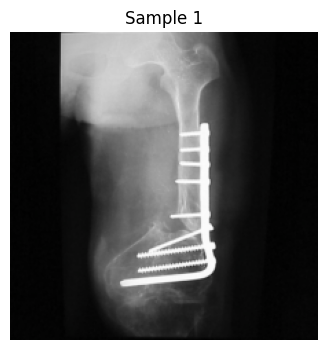

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: Post-operative Anterior-Posterior Radiograph Showing Approximation of Bone Ends, Condylar Plate Fixation and Iliac Bone Grafting
Model Pred  : Postoperative radiograph of the right hip joint showing the implant and the prosthesis. The implant is a titanium alloy with a diameter of 12 mm and a length of 10 mm. The prosthesis is a titanium alloy with a
--------------------------------------------------


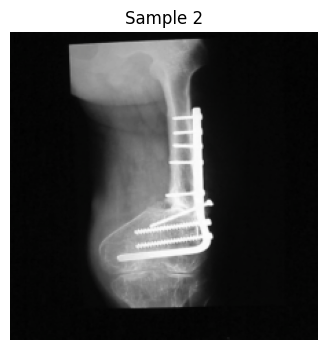

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: Anterior-posterior View After 7 Months of Weight Bearing in the Extension Brace, Showing Improved Bone Quality
Model Pred  : Anteroposterior radiograph of the left hip joint showing a fracture of the acetabulum. The fracture is located at the level of the acetabular rim and is not associated with any other bone lesion. The fracture is located in
--------------------------------------------------


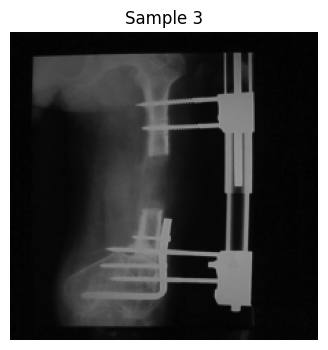

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: The FemurDuring Lengthening Using a Unilateral Frame. The plate is replaced by a shorter one, the osteotomy is done at the upper end of the plate and the Schanz screws are inserted through the plate holes.
Model Pred  : Anteroposterior radiograph of the left shoulder showing a fracture of the humerus. The fracture is located in the proximal third of the humerus. The fracture is not visible on the lateral view. The fracture is located in the
--------------------------------------------------


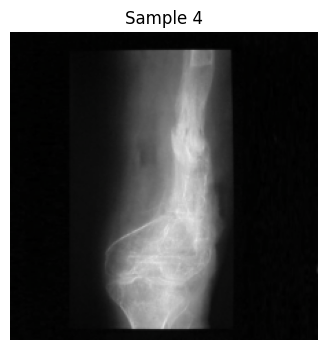

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: Anterior-Posterior View of the Femur at the End of Lengthening and Removal of the Frame
Model Pred  : Anteroposterior radiograph of the right hip joint showing a fracture of the acetabulum. The fracture is located at the level of the acetabular rim. The fracture is not visible on the lateral view. The fracture is
--------------------------------------------------


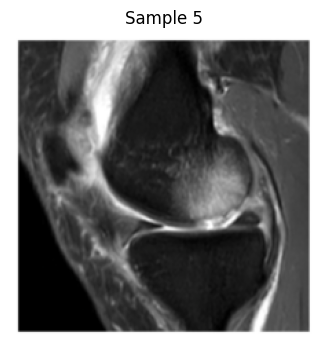

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: Sagittal T2-weighted MRI of left knee joint depicting cartilage lesion and large underlying BME at dorsomedial femoral condyle.
Model Pred  : CT scan of the pelvis showing the fracture of the left iliac bone. The arrow indicates the fracture site. The white arrow indicates the fracture site. The black arrow indicates the fracture site. The red arrow indicates the fracture site. The blue
--------------------------------------------------


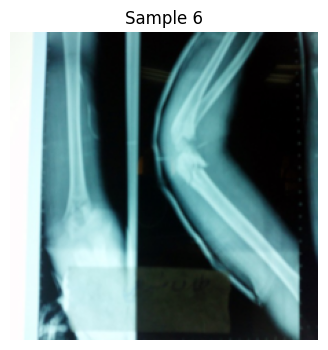

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: Displaced humerus supracondylar fracture in a 5 years old patient.
Model Pred  : Postoperative radiograph showing the screws and plates in place. The screws are placed in the distal femur and the plates are placed in the proximal tibia. The screws are placed in the proximal femur and the plates are placed in
--------------------------------------------------


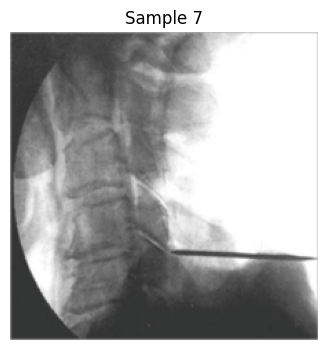

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: The K-wire is advanced slowly through the musculature under fluoroscopic guidance and docked on bone at the inferomedial edge of the rostral lateral mass at the target level.
Model Pred  : Anteroposterior radiograph of the right hip showing a 3.5 cm bone defect with a fracture line at the level of the acetabular rim. The fracture line is located at the level of the acetabular rim. The fracture
--------------------------------------------------


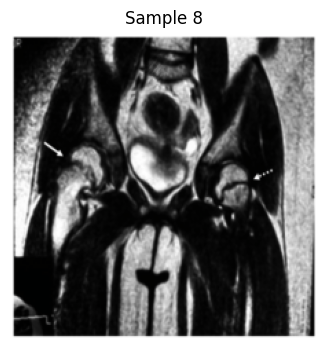

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant:  Preoperative MRI T2 image.A coronal MRI image shows bone marrow edema surrounding the right physis (arrow), but there were no findings suggesting pre-slip on the left (arrow of the thick dotted line).
Model Pred  : Computed tomography scan of the pelvis showing the fracture of the left iliac bone. The arrow indicates the fracture site. The arrow in the right side indicates the fracture site of the right iliac bone. The arrow in the left side indicates the f
--------------------------------------------------


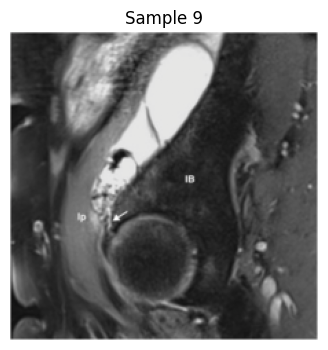

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: A giant synovial cyst incidentally found in the right hip of a 67-year-old woman during a routine computed tomography scan in the follow-up of a colorectal cancer in complete remission. For better characterization of the lesion, MRI was performed. Sagittal PD-WI shows a smooth, large multiloculated cyst, communicating with the joint space through a stalk (arrow). The lesion, probably corresponding to an enlarged iliop
Model Pred  : CT scan of the pelvis showing a large, well-defined, osteolytic lesion in the left iliac bone. The lesion is associated with a large, well-defined, osteolytic lesion in the right iliac bone. The lesion
--------------------------------------------------


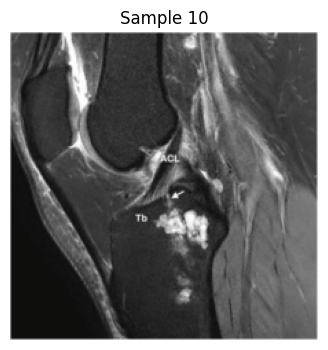

Ground Truth: User: Analyze this X-ray and describe the findings.
Assistant: Intraosseous ganglion cyst of the tibia incidentally depicted in a 40-year-old man who underwent an MRI scan due to intermittent, subacute non-specific knee pain. Sagittal FS PD-WI shows a metaepiphyseal, large, multiloculated cystic lesion of the tibia, which communicates with the articular surface through a thin stalk (arrow) extending into the intersp
Model Pred  : Sagittal T2-weighted MRI of the left knee joint. The lesion is located in the medial tibial plateau, with a thickening of the bone marrow and a signal abnormality in the surrounding soft tissues. The lesion is character
--------------------------------------------------


In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_results(num_samples=10):
    print(f"--- Testing {num_samples} Images ---")
    model.eval()

    test_iter = iter(dataset)

    for _ in range(20): next(test_iter)

    for i in range(num_samples):
        try:
            sample = next(test_iter)
        except StopIteration:
            print("Dataset exhausted.")
            break

        image_tensor = sample['pixel_values']

        labels = sample['labels']
        valid_labels = labels[labels != -100]
        real_text = tokenizer.decode(valid_labels, skip_special_tokens=True)

        generated_text = generate_medical_description(image_tensor)

        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_display = inv_normalize(image_tensor.clone().cpu()).permute(1, 2, 0).numpy()
        img_display = img_display.clip(0, 1)

        plt.figure(figsize=(4, 4))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
        plt.show()

        print(f"Ground Truth: {real_text}")
        print(f"Model Pred  : {generated_text}")
        print("-" * 50)

visualize_results()